# Problem formulation
The problem at hand is a binary classification task between two tetris pieces, the "I" and the "O". These pieces were chosen at random from the possible tetris pieces during my problem formulation time. To do this, images in the form of 4x4x1 matrices are fed to a CNN+FCNN, the performance of which is determined with binary cross-entropy and trained using stochastic gradient descent.

# Given
1. The network architecture  

| **Layer**   | **Input dim** | **Output dim** | **Other**                                                  |
|-------------|---------------|----------------|------------------------------------------------------------|
| Input       | 4x4           | 4x4            | "I" or "O" in input                                        |
| 2D convolve | 4x4           | 3x3            | Kernel: 2x2 with stride 1 and no padding. Activation: ReLU |
| Max pool    | 3x3           | 2x2            | Kernel: 2x2 with stride 1 and no padding.                  |
| Flatten     | 2x2           | 4x1            |                                                            |
| FCNN        | 4x1           | 1              | Activation: Sigmoid                                        |

which has a total of 10 parameters, decomposed into 2 biases from the CNN and FCNN, 4 kernel weights in the CNN and 4 weights in the FCNN.

2. An imput array as specified in the "Input" in 1.

# Find
1. The intermediate values in the network
2. Post-activation for a forward pass
3. Loss for a forward pass
3. Gradient of the loss function w.r.t. the network parameters


# Imports and helper functions

[0. 2. 2. 0. 2. 2. 0. 2. 2.]


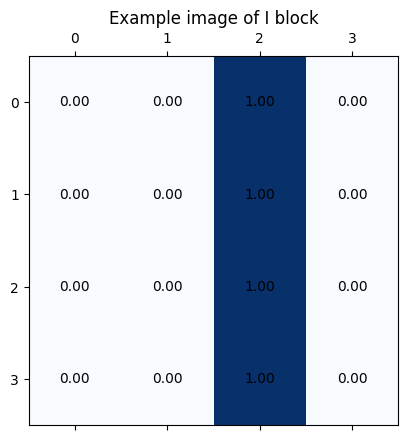

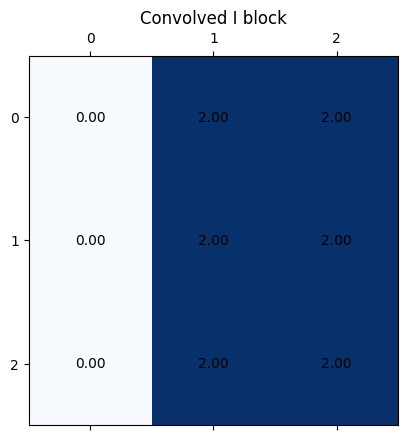

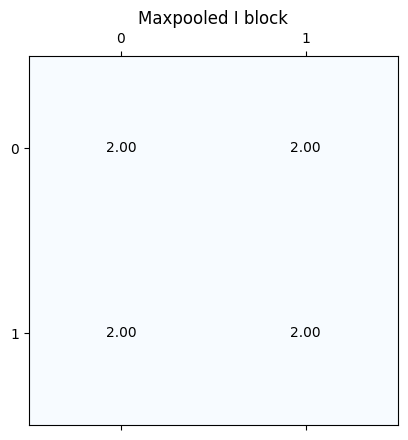

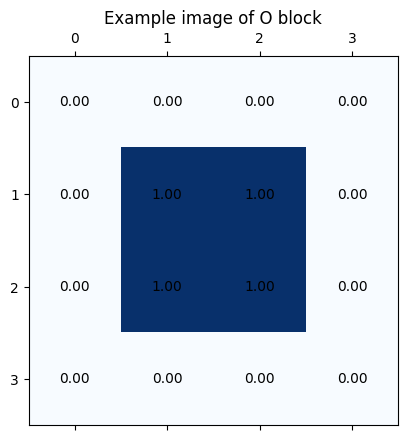

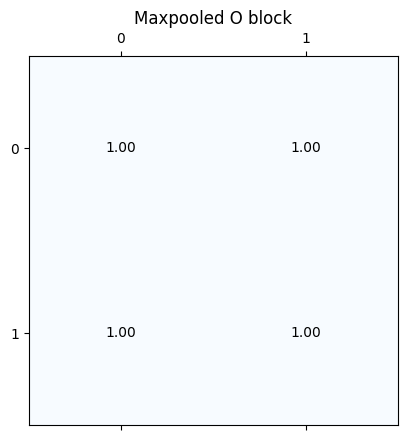

In [273]:
import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable

from __future__ import annotations
from itertools import product


class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.data: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, val):
        self.data[key] = val


    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.data, cmap=plt.cm.Blues)

        for y, x in np.ndindex(self.data.shape):
            ax.text(y, x, f"{self.data[x, y]:.2f}", va='center', ha='center')
        ax.set_title(title)


    # TODO: Fix padding
    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        """Convolve the 2D matrix with a 2D kernel plus bias

        See http://www.songho.ca/dsp/convolution/convolution2d_example.html for the math
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.data[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.data.flatten() \
                + bias 

        return Matrix2D(output_image)

    def maxpool(self, ndim: int = 1, stride: int = 1):
        """Dimension reduction using the max of a neigborhood defined by ndim

        See https://computersciencewiki.org/index.php/Max-pooling_/_Pooling for the math
        """
        output_width: int = (self.nrow - ndim) // stride + 1
        output_height: int = (self.ncol - ndim) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for row, col in product(range(output_width), range(output_height)):
            rows = slice(row * ndim, (row+1) * ndim)
            cols = slice(col * ndim, (col+1) * ndim)

            output_image[row, col] = np.max(self.data[rows, cols])

        return Matrix2D(output_image)

    def flatten(self):
        return self.data.flatten()



# TODO: Make compatible with arrays and matrices?
# TODO: Alternatively remove class and just pass bool
class Network():
    def __init__(self, backward: bool = False):
        self.backward = backward

    def relu(self, value: float) -> float:
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * value

    def sigmoid(self, value: float) -> float:
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act


nn = Network()


# Data 
# K = Matrix2D(np.array(([[1, 1], [1, 1]])))
# I = Matrix2D(np.zeros((4, 4)))
# I[:4, 2] = 1
# I.draw("Example image of I block")
# IC = I.convolve2D(K)
# IC.draw("Convolved I block")


# IM = IC.maxpool(2, 1)
# IM.draw("Maxpooled I block")


# O = Matrix2D(np.zeros((4, 4)))
# O[1:3, 1:3] = 1
# O.draw("Example image of O block")
# OM = O.maxpool(2, 2)
# OM.draw("Maxpooled O block")



# Forward pass

In [241]:
"""Do forward pass here"""

'Do forward pass here'

In [242]:

class Float:
    """A wrapper class for numbers in the network that adds additional
    functionality like storing the gradient to allow for easy backward
    propagation
    """

    def __init__(self, value, children=()):
        self.value = value
        self.grad = 0
        # internal variables used for autograd graph construction
        self.backward = lambda: None
        self.children = set(children)

    def __cast_to_self(self, other):
        return other if isinstance(other, Float) else Float(other)

    def __add__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value + other.value, (self, other))

        def backward() -> None:
            self.grad += out.grad
            other.grad += out.grad

        out.backward = backward
        
        return out

    def __mul__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value * other.value, (self, other))

        def backward() -> None:
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        
        out.backward = backward

        return out

    def __pow__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value**other, (self,))

        def backward() -> None:
            self.grad += (other * self.value**(other - 1)) * out.grad

        out.backward = backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        
    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Float(data={self.value}, grad={self.grad})"


    # Below is a collection of activation functions

    def relu(self) -> Float:
        value = max(0, self.value)
        out = Float(value, (self,))

        def backward() -> None:
            self.grad += (value > 0) * out.grad

        out.backward = backward

        return out

    def tanh(self) -> Float: 
        raise NotImplementedError

    def abs(self) -> Float:
        raise NotImplementedError
    
    def linear(self) -> Float:
        raise NotImplementedError

    
    # The main workhorse of the backwards pass

    def backward_pass(self):
        """The main algorithm for a backwards pass. Works by topologically
        sorting all connected nodes then iteratively and reversely calling
        backwards on the sorted list.
        """
        nodes_sorted = []
        nodes_visited = []

        def topological_sort(node) -> None:
            if node not in nodes_visited:
                nodes_visited.append(node)

                for child in node.children:
                    topological_sort(child)

                nodes_sorted.append(node)

        topological_sort(self)

        self.grad = 1 # Need to set this to non-zero, else all grads will be 0
        for node in reversed(nodes_sorted):
            node.backward()


# Micrograd inspired FCNN

In [243]:
class Base():
    
    def reset(self):
        for p in self.p():
            p.grad = 0

    def p(self):
        return []

In [244]:

class Neuron(Base):
    
    def __init__(self, n_inputs, f=None):
        """Create a neuron with n inputs.
        
        Optionally specify an activation function.
        If no activation function is set, a default one
        will be set. Right now that is f(x) = x
        """
        self.w = [Float(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Float(np.random.uniform())
        
        if f is None:
            self.f = lambda x : x # Linear
            #self.f = lambda x : max(x, 0) #ReLU
        else:
            self.f = f
    
    def z(self, x):
        """Calculate the pre-activation neuron output"""
        return x@self.w.T + self.b
    
    def a(self, x):
        """Calculate the post-activation neuron output"""
        return self.f(self.z(x))

    def p(self):
        """Return the weights of the neuron"""
        return [self.b] + self.w

    
# Test
#N = 3
#n = Neuron(N)
#x = np.random.rand(N)
#print(n.a(x))


In [245]:
class Layer(Base):
    
    def __init__(self, n_neurons, n_inputs):
        """Create a layer of n_neurons
        
        The amount of inputs to the neurons will also need to be specified.
        """
        self.neurons = [Neuron(n_inputs) for _ in range(n_neurons)]
        
    def out(self, x):
        """Return the vector of outputs of the layer"""
        return [n.out(x) for n in self.neurons]

    def p(self):
        """Return the parameters for all the neurons in the layer"""
        return [p for n in self.neurons for p in n.p()]
        
    
        
    

In [246]:
class FCNN(Base):
    
    def __init__(self, n_inputs, n_outputs):
        """Create a fully-connected network of n layers
        """
        sizes = [n_inputs] + n_outputs
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]
        
        
    def out(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def p(self):
        [p for l in self.layers for p in l.p()]
